# K-Nearest Neighbors (KNN) Classification – Lecture Notebook

This notebook demonstrates how to use **K-Nearest Neighbors (KNN)** for a **binary classification**
task using the IBM Employee Attrition dataset.

We will walk through:

1. Preparing predictors and target variables
2. Scaling features for distance-based learning
3. Training KNN classifiers with different values of _k_
4. Visualizing decision boundaries (2D projection)
5. Evaluating model performance

> **Key idea:**  
> KNN classifies observations based on _distance in predictor space_.  
> Feature scaling and encoding choices directly affect which points are considered “neighbors”.


## k-Nearest Neighbors (kNN) Classification

kNN is a **non‑parametric, instance‑based** learning algorithm.
Instead of learning explicit model parameters, it stores the training data
and makes predictions by comparing new observations to previously seen examples.

Key ideas:

- Distance defines _similarity_
- The label is inferred from the _k closest neighbors_
- Training is cheap; prediction is expensive


## Setup


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Feature Preprocessing


In [37]:
df = pd.read_csv("ibm_attrition.csv")

# Dropping columns with no significant contribution.
df.drop(columns=["EmployeeCount", "EmployeeNumber", "StandardHours"], inplace=True)

print(df.shape)

df.head()

(1470, 32)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [38]:
# Getting distribution of Attrition
df["Attrition"].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [39]:
# Encode target ("Attrition")


# [1, 0] = ["Yes", "No"]
label_map = {"No": 0, "Yes": 1}
df["Attrition"] = df["Attrition"].map(label_map)


# Or use LabelEncoder()
# target_encoder = LabelEncoder()
# df["Attrition"] = target_encoder.fit_transform(df["Attrition"])

# Sanity check to see if we still get the expected counts.
df["Attrition"].value_counts()

Attrition
0    1233
1     237
Name: count, dtype: int64

In [40]:
# Dropping categorical columns

categorical_cols = df.select_dtypes(include="object").columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("categorical columns that will be dropped:")
print(categorical_cols)
df.drop(columns=categorical_cols, inplace=True)

print(f"New df shape: {df.shape}")
df.head()

categorical columns that will be dropped:
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
New df shape: (1470, 24)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,1102,1,2,2,94,3,2,4,...,3,1,0,8,0,1,6,4,0,5
1,49,0,279,8,1,3,61,2,2,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1,1373,2,2,4,92,2,1,3,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1392,3,4,4,56,3,1,3,...,3,3,0,8,3,3,8,7,3,0
4,27,0,591,2,1,1,40,3,1,2,...,3,4,1,6,3,3,2,2,2,2


In [41]:
## Forming X and y sets

y = df["Attrition"]

X = df.drop(columns=["Attrition"])

## Train/Test Splitting


In [42]:
# Splitting train and test sets. Note that we split data before scaling to prevent any leakage from
# test set to our training process.
# Also note the use of stratification.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2026, stratify=y
)

for v in [X_train, X_test, y_train, y_test]:
    print(v.shape)

(1102, 23)
(368, 23)
(1102,)
(368,)


In [43]:
# Scaling training and test set. Note that we ONLY use training set for calculating scaling parameters.

train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

# Alternatively you can use StandardScaler() class which does the same thing.
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# # You could also call .fit_transform() method once instead of two steps above.
# X_test_scaled = scaler.transform(X_test)


# We use np.isclose() and np.allclose() methods to account for computation precision.
# the actual values are very close to 0 but not exactly 0.
print(np.allclose(X_train_scaled.mean(axis=0), 0))
print(np.allclose(X_train_scaled.std(axis=0), 1))
print("\n")

# You can see that unlike training data,test data is not exactly standardized to mean of 0 and std of 1.
# This is expected as we used training dataset for calculating standardization parameters.
print(np.allclose(X_test_scaled.mean(axis=0), 0))
print(np.allclose(X_test_scaled.std(axis=0), 1))
X_test_scaled.columns[0]
print("\n")

# The use of stratification during splitting results in train and test splits with almost
# equal distribution on target (y).
print(f"Average for y_train: {y_train.mean():.3f} and for y_test: {y_test.mean():.3f}")
print(np.isclose(y_train.mean(), y_test.mean(), atol=0.01))

True
True


False
False


Average for y_train: 0.162 and for y_test: 0.160
True


## Feature Selection


<Axes: >

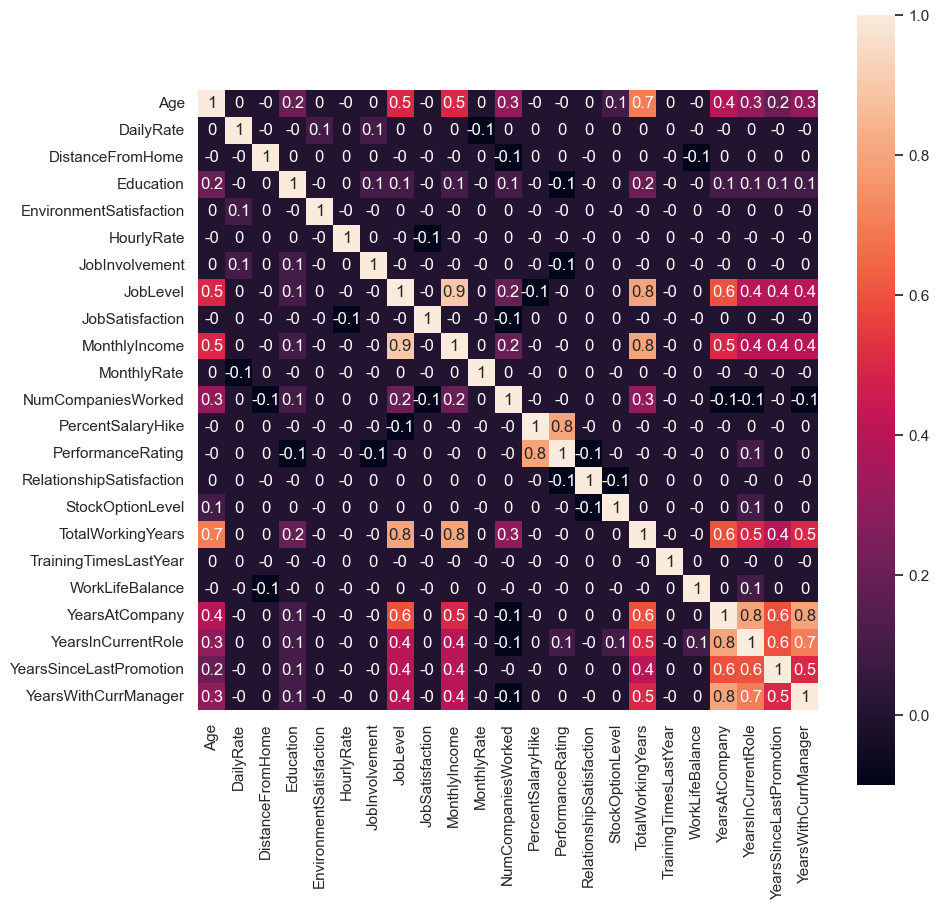

In [44]:
# A heatmap provides a good way of understanding multicollinearity between features.
# This helps with feature selection.abs
# Note that we are not using the test set to avoid leaking problem.

# We first assemble back the training set by combining X and y values previously split.
train_df = pd.concat([X_train, y_train], axis=1)

# Then we calculate the Pearson correlation.abs
# Note tha Pearson correlation is location and scale invariant.abs
# You could take the correlation of non-scaled or scaled data and they will be equal.
corr = train_df.corr().round(2)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    train_df.drop(columns="Attrition").corr().round(1), annot=True, square=True, ax=ax
)

In [45]:
# Filtering and storing the pairs of feaures that are highly correlated.
multicol_threshold = 0.5

mask = np.triu(np.ones(corr.shape), k=1).astype(bool)  # upper triangle, no diagonal
pairs = corr.where(mask).stack().reset_index()
pairs.columns = ["feat1", "feat2", "corr"]
pairs = pairs[pairs["corr"].abs() >= multicol_threshold].sort_values(by="feat1")

pairs

,feat1,feat2,corr
6,Age,JobLevel,0.53
8,Age,MonthlyIncome,0.52
15,Age,TotalWorkingYears,0.71
141,JobLevel,MonthlyIncome,0.95
148,JobLevel,TotalWorkingYears,0.79
151,JobLevel,YearsAtCompany,0.56
177,MonthlyIncome,TotalWorkingYears,0.77
180,MonthlyIncome,YearsAtCompany,0.54
210,PercentSalaryHike,PerformanceRating,0.77
250,TotalWorkingYears,YearsAtCompany,0.65


In [46]:
# Filtering out and storing features with high correlation to target (y).
target_cor_threshold = 0.1

highly_corr = corr.loc[corr["Attrition"].abs() >= target_cor_threshold, "Attrition"]
highly_corr

Age                       -0.18
EnvironmentSatisfaction   -0.10
JobInvolvement            -0.10
JobLevel                  -0.17
MonthlyIncome             -0.16
StockOptionLevel          -0.15
TotalWorkingYears         -0.18
YearsAtCompany            -0.15
YearsInCurrentRole        -0.18
YearsWithCurrManager      -0.19
Attrition                  1.00
Name: Attrition, dtype: float64

We select the final features we want to include based on previous steps. We want features that are not highly correlated but also potentially related to the target.


In [47]:
to_remove = ["TotalWorkingYears", "YearsInCurrentRole", "YearsAtCompany"]
extras = [
    "JobSatisfaction",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "WorkLifeBalance",
]
retained_features = [f for f in highly_corr.index.to_list() if f not in to_remove]
retained_features.extend(extras)
retained_features

['Age',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'MonthlyIncome',
 'StockOptionLevel',
 'YearsWithCurrManager',
 'Attrition',
 'JobSatisfaction',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'WorkLifeBalance']

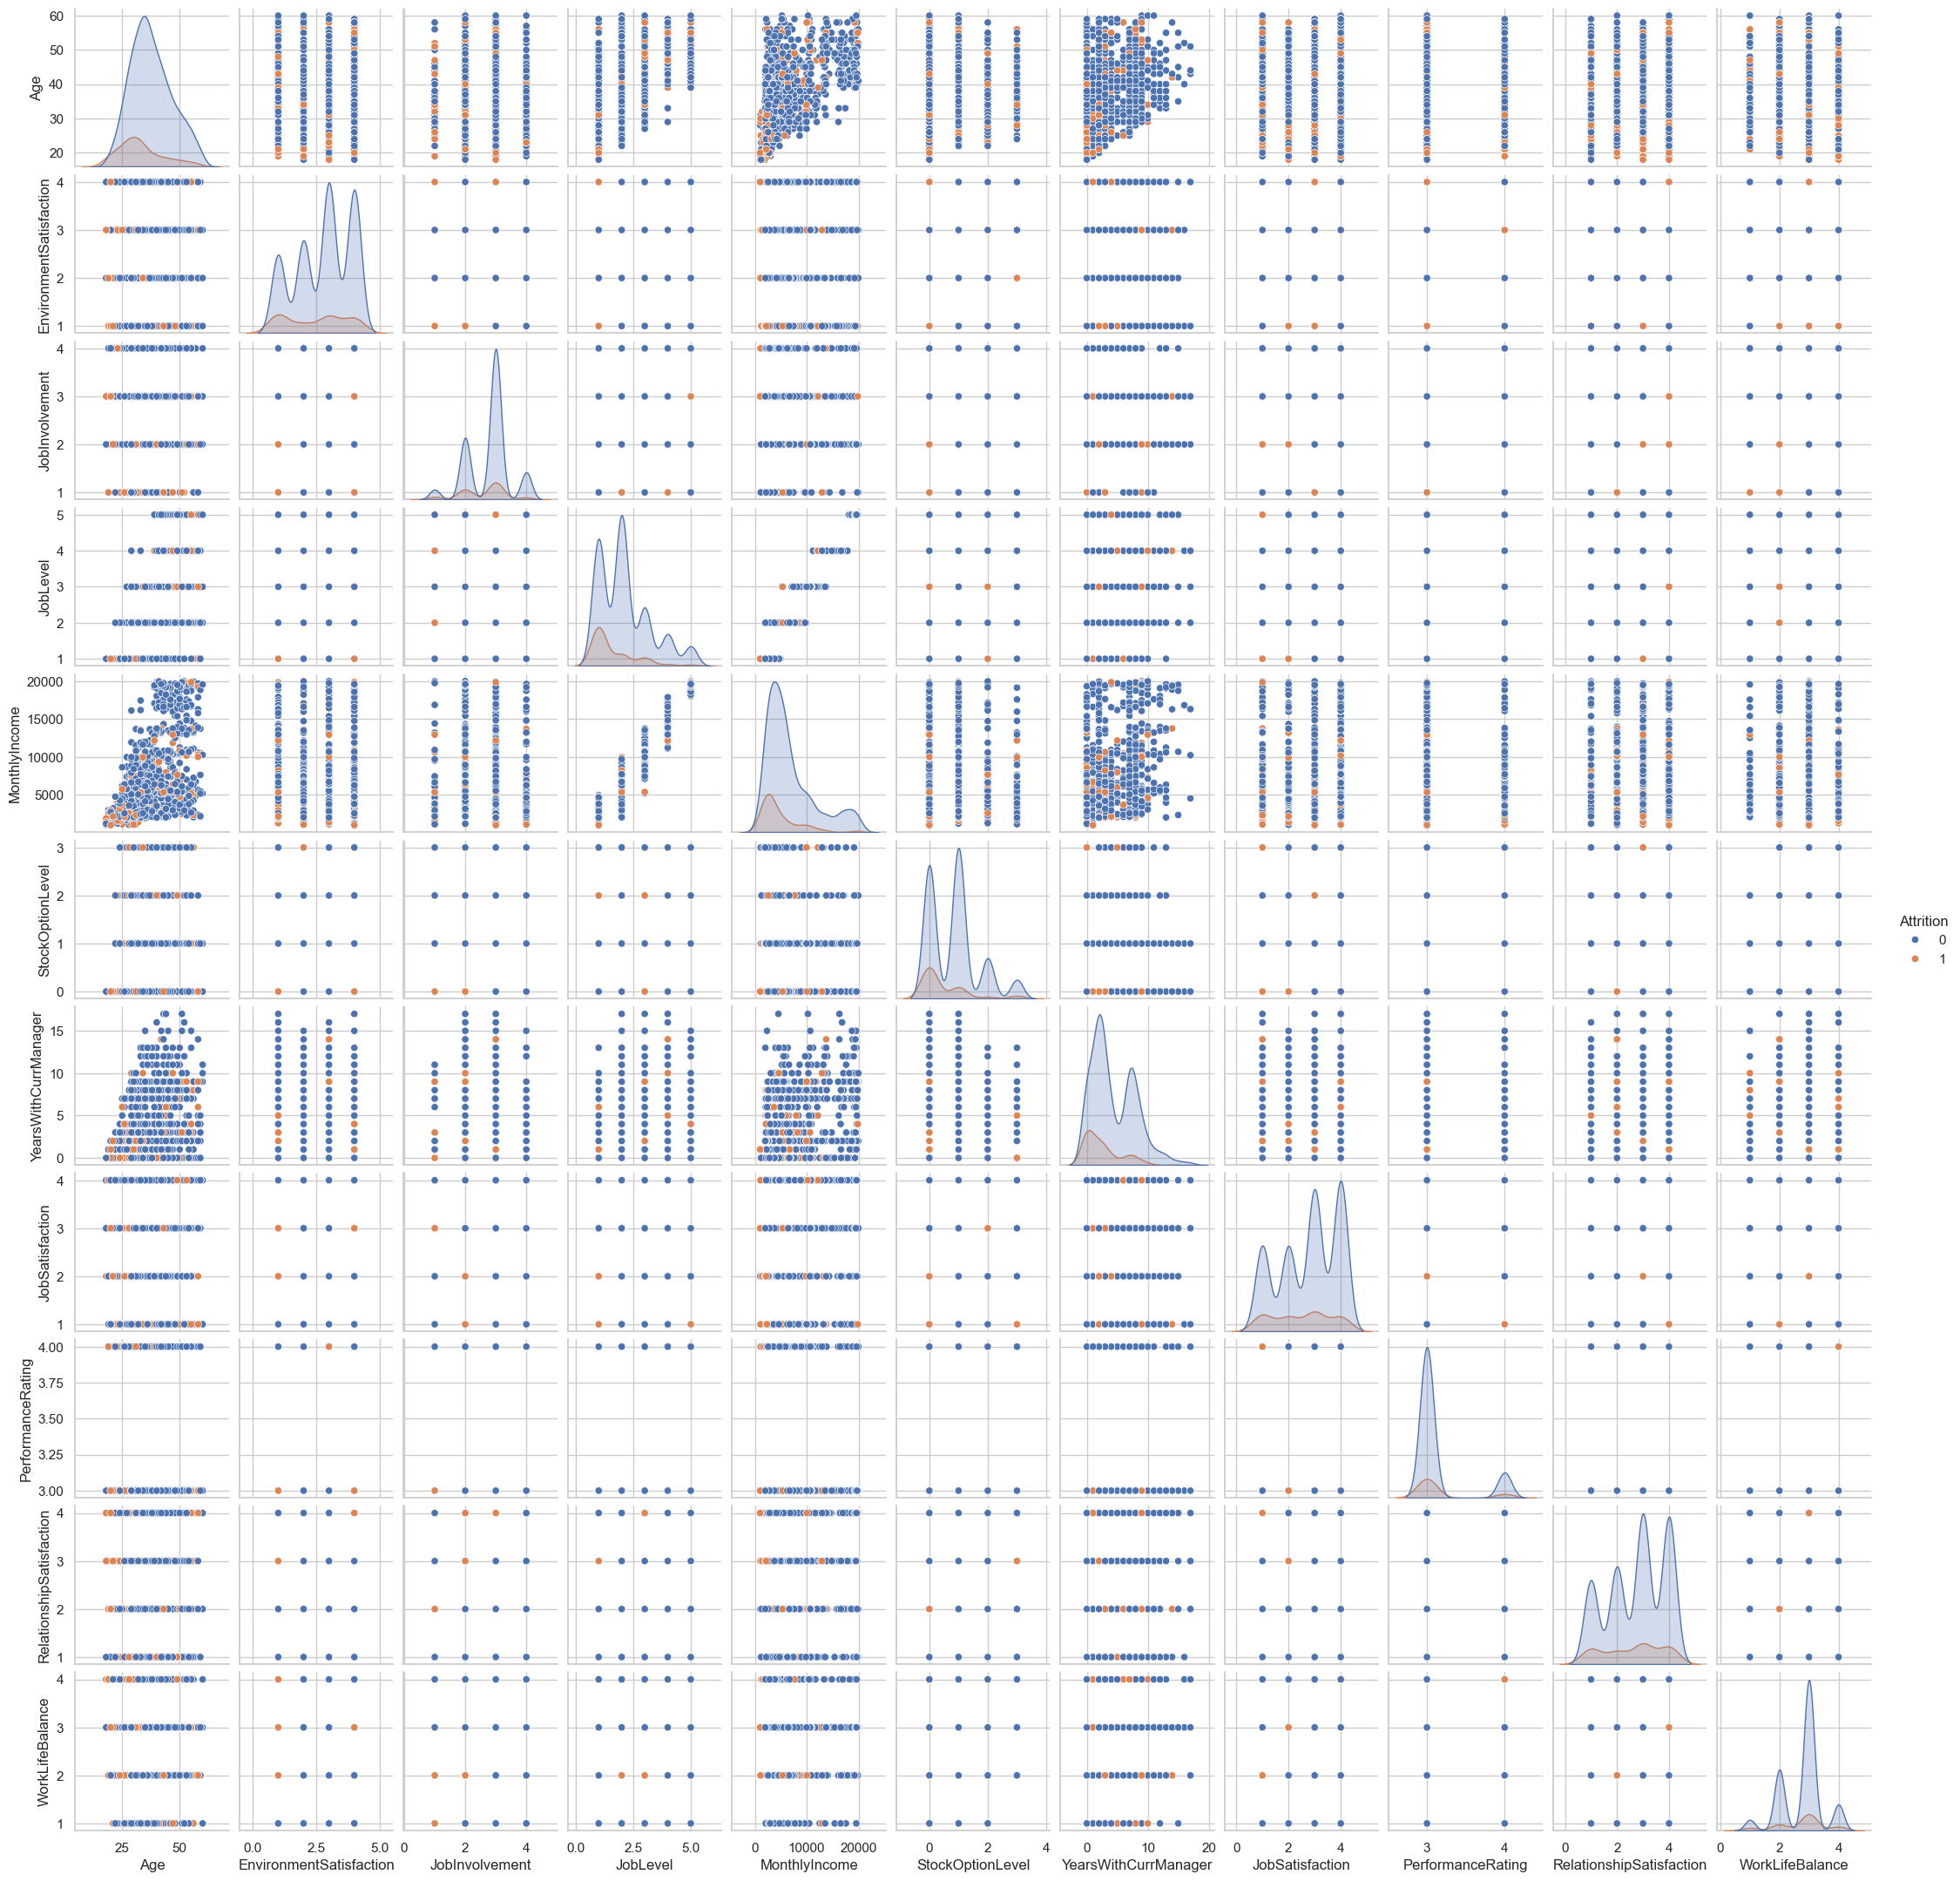

In [48]:
# Pairplot gives us a good indication of differential class distribution within each feature.

sns.pairplot(train_df[retained_features], hue="Attrition", height=2)

In [49]:
# Applying feature selection to training and test splits

retained_features.remove("Attrition")

X_train_retained = X_train_scaled[retained_features]
X_test_retained = X_test_scaled[retained_features]

## Model Fitting and Prediction

Here we instantiate and fit a `KNeighborsClassifier`.
At this stage, the model simply stores the training data and configuration
(e.g., number of neighbors and distance metric).


In [50]:
# Fitting a number of models with a number of k parameters.
# We store the resulting accuracies in lists

k_values = [3, 5, 7, 11, 15, 25, 50]
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_retained, y_train)

    train_pred = knn.predict(X_train_retained)
    test_pred = knn.predict(X_test_retained)

    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

    # Alternatively instead of .predict() and accuracy_score() you could do it in one step using .score()
    # train_accuracies.append(knn.score(X_train_retained, y_train))
    # test_accuracies.append(knn.score(X_test_retained, y_test))

In [51]:
train_accuracies, test_accuracies

([0.8901996370235935,
  0.8793103448275862,
  0.8638838475499092,
  0.8566243194192378,
  0.852087114337568,
  0.8466424682395645,
  0.8393829401088929],
 [0.8233695652173914,
  0.8260869565217391,
  0.8288043478260869,
  0.8233695652173914,
  0.8369565217391305,
  0.842391304347826,
  0.8396739130434783])

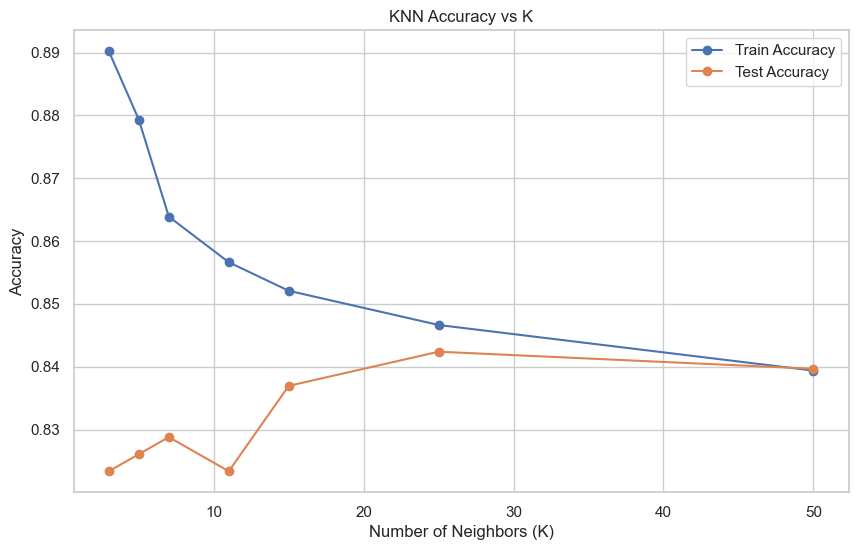

In [52]:
# Plotting the accuracy and k

plt.plot(k_values, train_accuracies, marker="o", label="Train Accuracy")
plt.plot(k_values, test_accuracies, marker="o", label="Test Accuracy")


plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs K")
plt.legend()
plt.show()

## Plotting Decision Boundaries

Predictions are made by computing distances between a new observation
and _all_ stored training points, then aggregating the labels of the
closest neighbors.


In [53]:
# Creating a function to facilitate plotting.

def plot_decision_boundary(ax, X, y, k, feature_names, class_labels):
    """
    This function creates a mesh-grid filling up the entire data space
    Then predicts assigned labels for the entire mesh-grid
    The resulting predictions consitute the hypothetical decision boundary
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap="coolwarm",
        edgecolor="k",
        s=40,
    )

    ax.set_xlabel(f"{feature_names[0]} (Scaled)")
    ax.set_ylabel(f"{feature_names[1]} (Scaled)")
    ax.set_title(f"KNN Decision Boundary (k={k})")

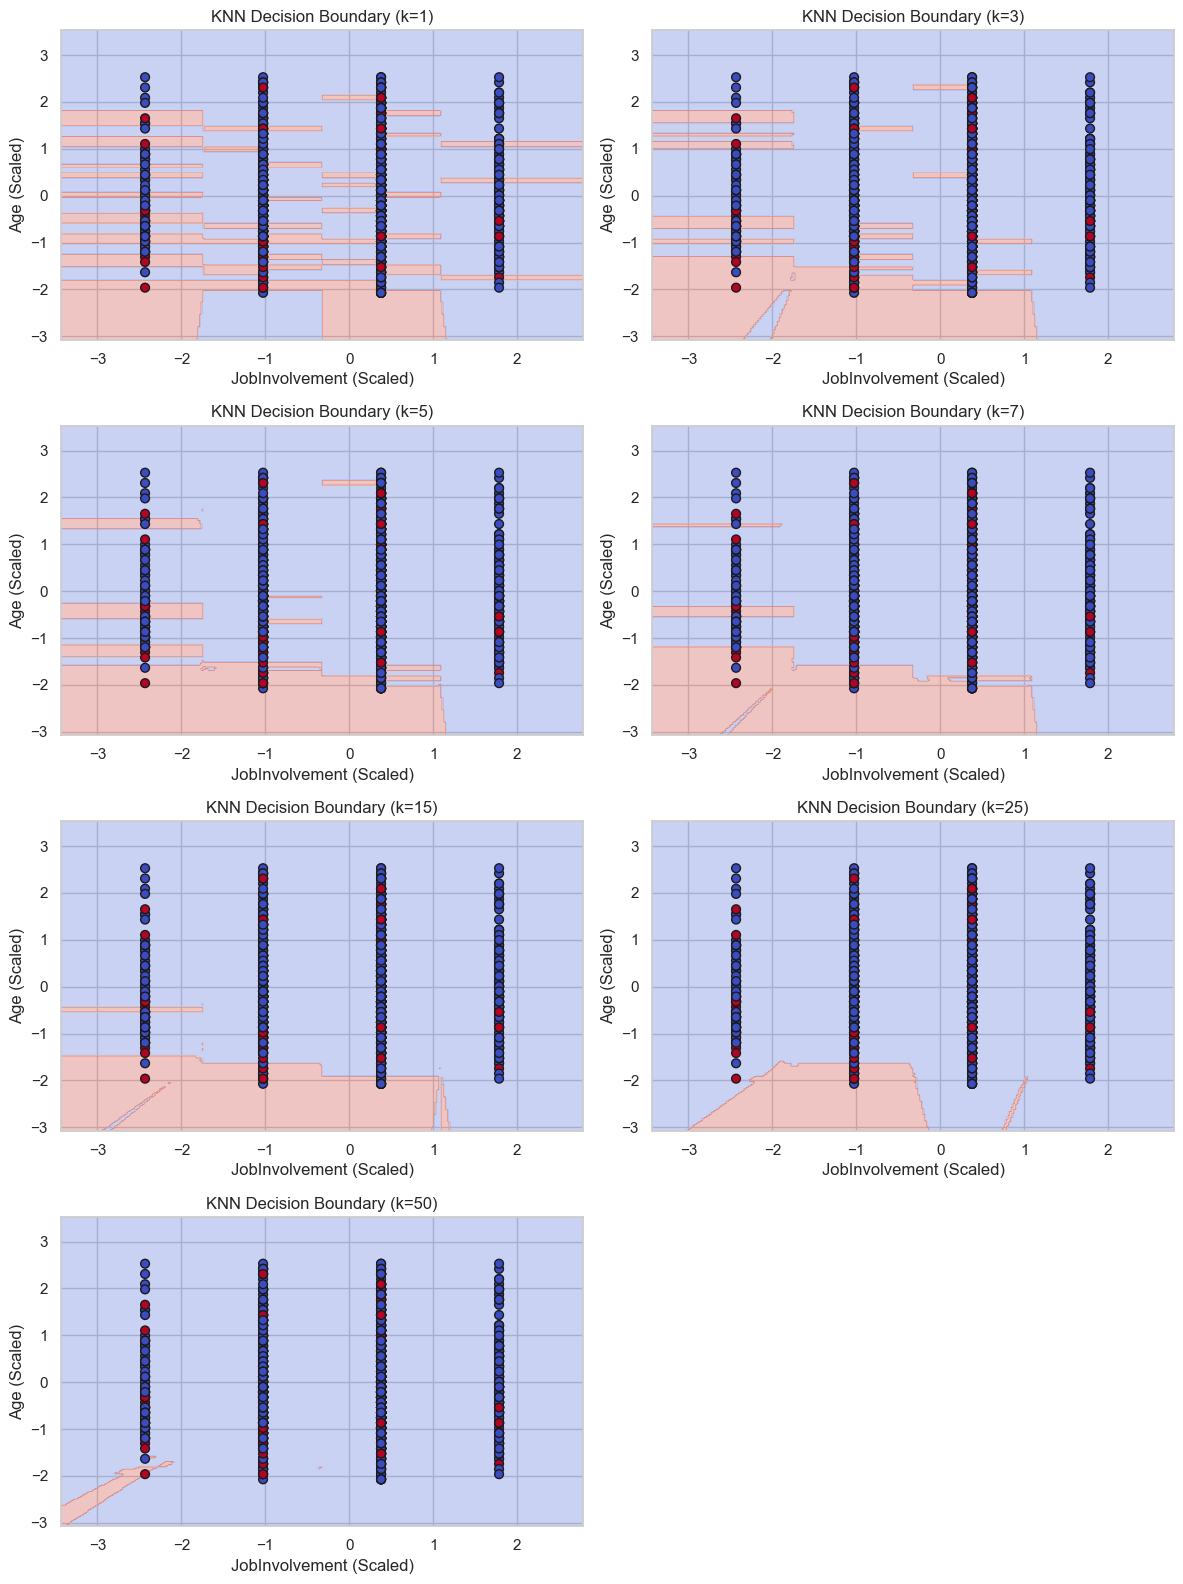

In [54]:
# Plotting decision boundaries for a smaller model on a number of k values

k_values = [1, 3, 5, 7, 15, 25, 50]
selected_features = ["JobInvolvement", "Age"]
X_2d = df[selected_features]

scaler_2d = StandardScaler()

X_2d_scaled = scaler_2d.fit_transform(X_2d)

n_rows = (len(k_values) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for ax, k in zip(axes, k_values):
    plot_decision_boundary(
        ax=ax,
        X=X_2d_scaled,
        y=y,
        k=k,
        feature_names=selected_features,
        class_labels=["No Attrition", "Attrition"],
    )

# Hide unused axes
for ax in axes[len(k_values) :]:
    ax.axis("off")

plt.tight_layout()

## Model Evaluation

We evaluate classification performance using standard metrics such as
accuracy and confusion matrices, which summarize correct and incorrect predictions.


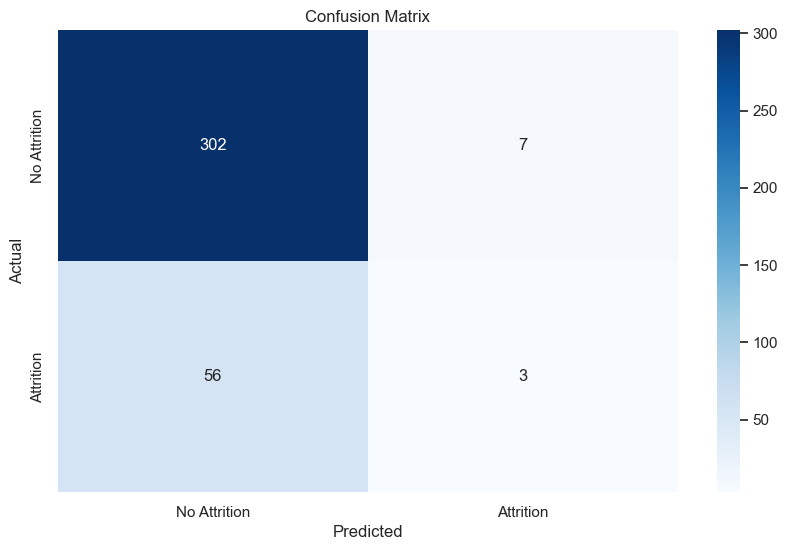

In [55]:
# We first fit our final model

final_knn = KNeighborsClassifier(n_neighbors=7)
final_knn.fit(X_train_retained, y_train)


y_pred = final_knn.predict(X_test_retained)

# We create a confusion matrix to evaluate model predictions
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Attrition", "Attrition"],
    yticklabels=["No Attrition", "Attrition"],
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [56]:
# Using other evaluation functions from sklearn.metrics

print(classification_report(y_test, y_pred, target_names=["No Attrition", "Attrition"]))

              precision    recall  f1-score   support

No Attrition       0.84      0.98      0.91       309
   Attrition       0.30      0.05      0.09        59

    accuracy                           0.83       368
   macro avg       0.57      0.51      0.50       368
weighted avg       0.76      0.83      0.77       368



## Examination of Model Object

In [ ]:
# Examining the final fitted model object

dir(final_knn)  # Obtain all available properties of an object

print(f"Stored X matrix shape: {final_knn._fit_X.shape}")
print(f"Stored y vector shape: {final_knn._y.shape}")
print(f"K parameter used: {final_knn.n_neighbors}")
print(f"Distance metric used: {knn.metric}")
print(f"Weighting scheme used: {knn.weights}")

Stored X matrix shape: (1102, 11)
Stored y vector shape: (1102,)
K parameter used: 7
Distance metric used: minkowski
Weighting scheme used: uniform


<!-- train_df = pd.concat() -->
